# Description - Generate Group Level Schaeffer Atlas 

The purpose of this notebook is to generate a version of the Schaeffer Atlas that only contains ROI with a minimum of 75 voxels once the atlas has been limited to the GM ribbon of all subjects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Minimum_NumVoxels_Size = 75

***
# Combine indivudual subject GM ribbon masks and apply to the Atlas

```bash
cd /data/SFIMJGC_HCP7T/HCP7T/ALL
# Calculate group-level GM mask
# =============================
3dMean     -overwrite -prefix ROI.ALL.GM.mPP.avg.nii.gz ../??????/ROI.GM.mPP.nii.gz
3dcalc     -overwrite -a ROI.ALL.GM.mPP.avg.nii.gz -expr 'step(a-0.5)' -prefix ROI.ALL.GM.mPP.mask.nii.gz
# Resample original Shaeffer Atlas to mPP grid
# ============================================
3dresample -overwrite -input ../Atlases/Schaefer2018_200Parcels_7Networks/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz \
           -rmode NN -master ROI.ALL.GM.mPP.mask.nii.gz -prefix Schaefer2018_200Parcels_7Networks_order_mPP.nii.gz
@MakeLabelTable -lab_file ../Atlases/Schaefer2018_200Parcels_7Networks/Schaefer2018_200Parcels_7Networks_order.txt 1 0 \
                -labeltable Schaefer2018_200Parcels_7Networks_order_mPP.niml.lt -dset Schaefer2018_200Parcels_7Networks_order_mPP.nii.gz
# Restrict Atlas to only voxels in the group-level GM mask
# ========================================================
3dcalc     -overwrite -a Schaefer2018_200Parcels_7Networks_order_mPP.nii.gz -b ROI.ALL.GM.mPP.mask.nii.gz \
           -expr 'a*b' -prefix rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz
@MakeLabelTable -lab_file ../Atlases/Schaefer2018_200Parcels_7Networks/Schaefer2018_200Parcels_7Networks_order.txt 1 0 \
                -labeltable Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.niml.lt -dset rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz
# Gather information about size of ROIs after being constrained to the group-level GM ribbon
# ==========================================================================================
3dROIstats -nzvoxels -mask rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz \
                           rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz > rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.info.txt
```

***
# Check for excessively small ROIs

Given the imaging FOV, some lower ROIs end up with only a handful of valid voxels. It is better to remove those from the atlas to avoid issues later.

The code below does the following:

* Loads into memory the information obtained from 3dROIstats above: for each ROI we have the ROI ID and the number of voxels in the ROI
* Re-arranges that information into a dataframe so that is it easy to us
* Finds the ROIs with less voxels than the set threshold of 75 voxels
* Prints information to the screen about which ROIs are those

In [3]:
# Load information about ROI sizes
aux_roi_info = pd.read_csv('/data/SFIMJGC_HCP7T/HCP7T/ALL/rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.info.txt', sep='\t').T.drop(['File','Sub-brick'])

In [4]:
# Extract columns with ROI IDs (mean) and Number of voxles (NZcount) as well as a clean list of ROI Names
mean_indexes  = [c for c in aux_roi_info.index if 'Mean'    in c]
nzvox_indexes = [c for c in aux_roi_info.index if 'NZcount' in c]
roi_indexes   = [(c.split('_',2)[2]).strip() for c in aux_roi_info.index if 'Mean'    in c]

In [5]:
# Reformat the information in a way that it is easily manageable
roi_info = pd.DataFrame(columns=['ROI ID','ROI Size'], index=roi_indexes)
roi_info['ROI ID']   = aux_roi_info.loc[mean_indexes].values
roi_info['ROI ID']   = roi_info['ROI ID'].astype(int)
roi_info['ROI Size'] = aux_roi_info.loc[nzvox_indexes].values

Text(0.5, 1.0, 'Distribition of ROI Sizes in Schaeffer Atlas (GM Ribbon)')

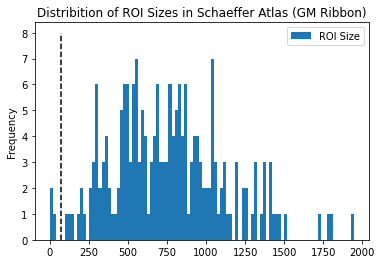

In [10]:
%matplotlib inline
# Histogram of ROI Sizes
# ======================
fig = roi_info.plot.hist(y='ROI Size', bins=100)
plt.plot([Minimum_NumVoxels_Size, Minimum_NumVoxels_Size],[0,8],'k--')
fig.set_title('Distribition of ROI Sizes in Schaeffer Atlas (GM Ribbon)')

In [11]:
# List of ROIs to remove from the Atlas
# =====================================
roi_info[roi_info['ROI Size'] < Minimum_NumVoxels_Size]

,ROI ID,ROI Size
LH_Limbic_OFC_2,56,20
LH_Default_Temp_2,75,31
RH_Limbic_OFC_1,159,1


In [12]:
rois_to_delete = list(roi_info[roi_info['ROI Size'] < Minimum_NumVoxels_Size]['ROI ID'].values)
print(rois_to_delete)

[56, 75, 159]


In [13]:
print('++ INFO: Final Number of ROIs in ATLAS = %d' % roi_info[roi_info['ROI Size'] >= Minimum_NumVoxels_Size].shape[0])

++ INFO: Final Number of ROIs in ATLAS = 197


In addition, it looks like some additional ROIs may cause issues later becuase they have flat time series

* 191 (flat timeseries 146735/rfMRI_REST1_PA) --> hemispheric equivalent: 84

In [14]:
rois_to_delete = rois_to_delete + [191, 84]
print('++ INFO: Final Number of ROIs in ATLAS = %d' % (roi_info.shape[0] - len(rois_to_delete)))
rois_to_delete

++ INFO: Final Number of ROIs in ATLAS = 195


[56, 75, 159, 191, 84]

***
# Create an updated Label Table file with only the remaining ROIs

When ROIs are removed, you end up with a discontinued set of ROI IDs. This is not optimal and needs to be corrected. To do so, we need to:

* Create a new label file with only the remaining ROIs and with the ROI IDs changed to their rank
* Create a new AFNI dataset with the ROIs also changed to their rank
* Attach the new label file to the new ROI AFNI dataset so that we have a correct final parcellation

Outputs:

* ```Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon_order.txt```: Correct label table file for the final version of the atlas
* ```Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz```: Correct final version of the atlas

In [15]:
aux = pd.read_csv('/data/SFIMJGC_HCP7T/HCP7T/Atlases/Schaefer2018_200Parcels_7Networks/Schaefer2018_200Parcels_7Networks_order.txt',sep='\t', header=None)
aux = aux.drop(rois_to_delete)
aux.index = np.arange(aux.shape[0]) + 1
aux = aux.drop(0,axis=1)
aux.to_csv('/data/SFIMJGC_HCP7T/HCP7T/ALL/Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon_order.txt', sep='\t', header=None)

***

# Create an updated Coordinate File for the Atlas

In [16]:
Nw2Id={'Vis':1,'SomMot':2,'DorsAttn':3,'SalVentAttn':4,'Limbic':5,'Cont':6,'Default':7}

In [17]:
aux = pd.read_csv('/data/SFIMJGC_HCP7T/HCP7T/Atlases/Schaefer2018_200Parcels_7Networks/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
aux = aux.drop(rois_to_delete)
aux = aux.reset_index(drop=True)
aux['Short ROI Name'] = [n.split('_',1)[1] for n in aux['ROI Name']]
aux['Node Size']  = 1
aux['Node Color'] = [Nw2Id[n.split('_')[2]] for n in aux['ROI Name']]
aux['ROI Label']  = aux.index + 1
aux

,ROI Label,ROI Name,R,A,S,Short ROI Name,Node Size,Node Color
0,1,7Networks_LH_Vis_1,-24,-54,-10,LH_Vis_1,1,1
1,2,7Networks_LH_Vis_2,-26,-78,-14,LH_Vis_2,1,1
2,3,7Networks_LH_Vis_3,-46,-70,-8,LH_Vis_3,1,1
3,4,7Networks_LH_Vis_4,-10,-68,-4,LH_Vis_4,1,1
4,5,7Networks_LH_Vis_5,-26,-96,-12,LH_Vis_5,1,1
...,...,...,...,...,...,...,...,...
190,191,7Networks_RH_Default_PFCdPFCm_6,28,30,42,RH_Default_PFCdPFCm_6,1,7
191,192,7Networks_RH_Default_PFCdPFCm_7,24,24,54,RH_Default_PFCdPFCm_7,1,7
192,193,7Networks_RH_Default_pCunPCC_1,12,-54,14,RH_Default_pCunPCC_1,1,7
193,194,7Networks_RH_Default_pCunPCC_2,6,-48,30,RH_Default_pCunPCC_2,1,7


In [18]:
aux.to_csv('/data/SFIMJGC_HCP7T/HCP7T/ALL/Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.Centroid_RAS.csv', sep=',', index=None)
aux[['R','A','S']].to_csv('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Resources/NBS_Node_Coordinates.txt', sep=' ', index=None, header=None)
aux['ROI Name'].to_csv('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Resources/NBS_Node_Labels.txt', sep=' ', index=None, header=None)

### Create BrainNetViewer Node File

In [19]:
aux[['R','A','S','Node Color','Node Size','Short ROI Name']].to_csv('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Resources/BrainNet_Nodes.node', sep=' ', index=None, header=None)

***
# Remove Small ROIs from the Atlas

Based on the information provided in the previous two cells, it looks like we need to eliminate 3 ROIs from the atlas to avoid future isses regarding working with small ROIs for which we may have only a few bad voxels at the borders. To do that, please run the following code:

```bash
cd /data/SFIMJGC_HCP7T/HCP7T/ALL
3dcalc -overwrite -a rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz \
       -expr 'a-56*equals(a,56)-75*equals(a,75)-159*equals(a,159)-191*equals(a,191)-84*equals(a,84)' \
       -prefix rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz

3dmerge -overwrite -1rank \
        -prefix Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz \
        rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz       
       
@MakeLabelTable -lab_file  Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon_order.txt 1 0 \
                -labeltable Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.niml.lt\
                -dset Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz

rm rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.info.txt
rm rm.Schaefer2018_200Parcels_7Networks_order_mPP.GM_Ribbon.nii.gz
```

> **NOTE:** Be aware that the ROIs being eliminated are hardcoded in the 3dcalc command. If those need to be changed, you will need to change that command accordingly